In [1]:
import pandas as pd
import scipy
from scipy import stats
import diffupy
from network_analysis import *
from matplotlib import pyplot
import random
from plotting import *
from phospho_analysis import *
import sys

# temp fix for dark preview pane problem
# pyplot.style.use('dark_background')

# autoload modules, so that if code changes in library it's reflected
%load_ext autoreload
%autoreload 2

## Load network and phospho data

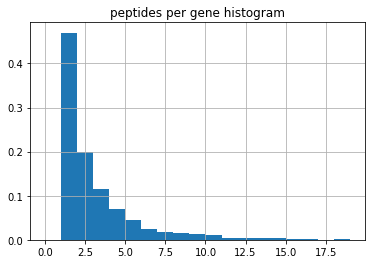

Common protein ids: 951, out of 1595 in phospho data and 6732 in network


In [2]:
ppi = read_network("data/BIOGRID-PUBLICATION-13022-4.1.190.tab3.txt")
phospho_data = read_phospho_data("data/final_ascored_pep_tgr09076_09614.csv")
phospho_data = aggregate_peptide_values(phospho_data)
phospho_data = restrict_to_common_ids(phospho_data, ppi)

seed = 45
# random.seed(seed)
# ppi = ppi.subgraph(random.sample(sorted(phospho_data.index), 700))

## Network and phospho data properties

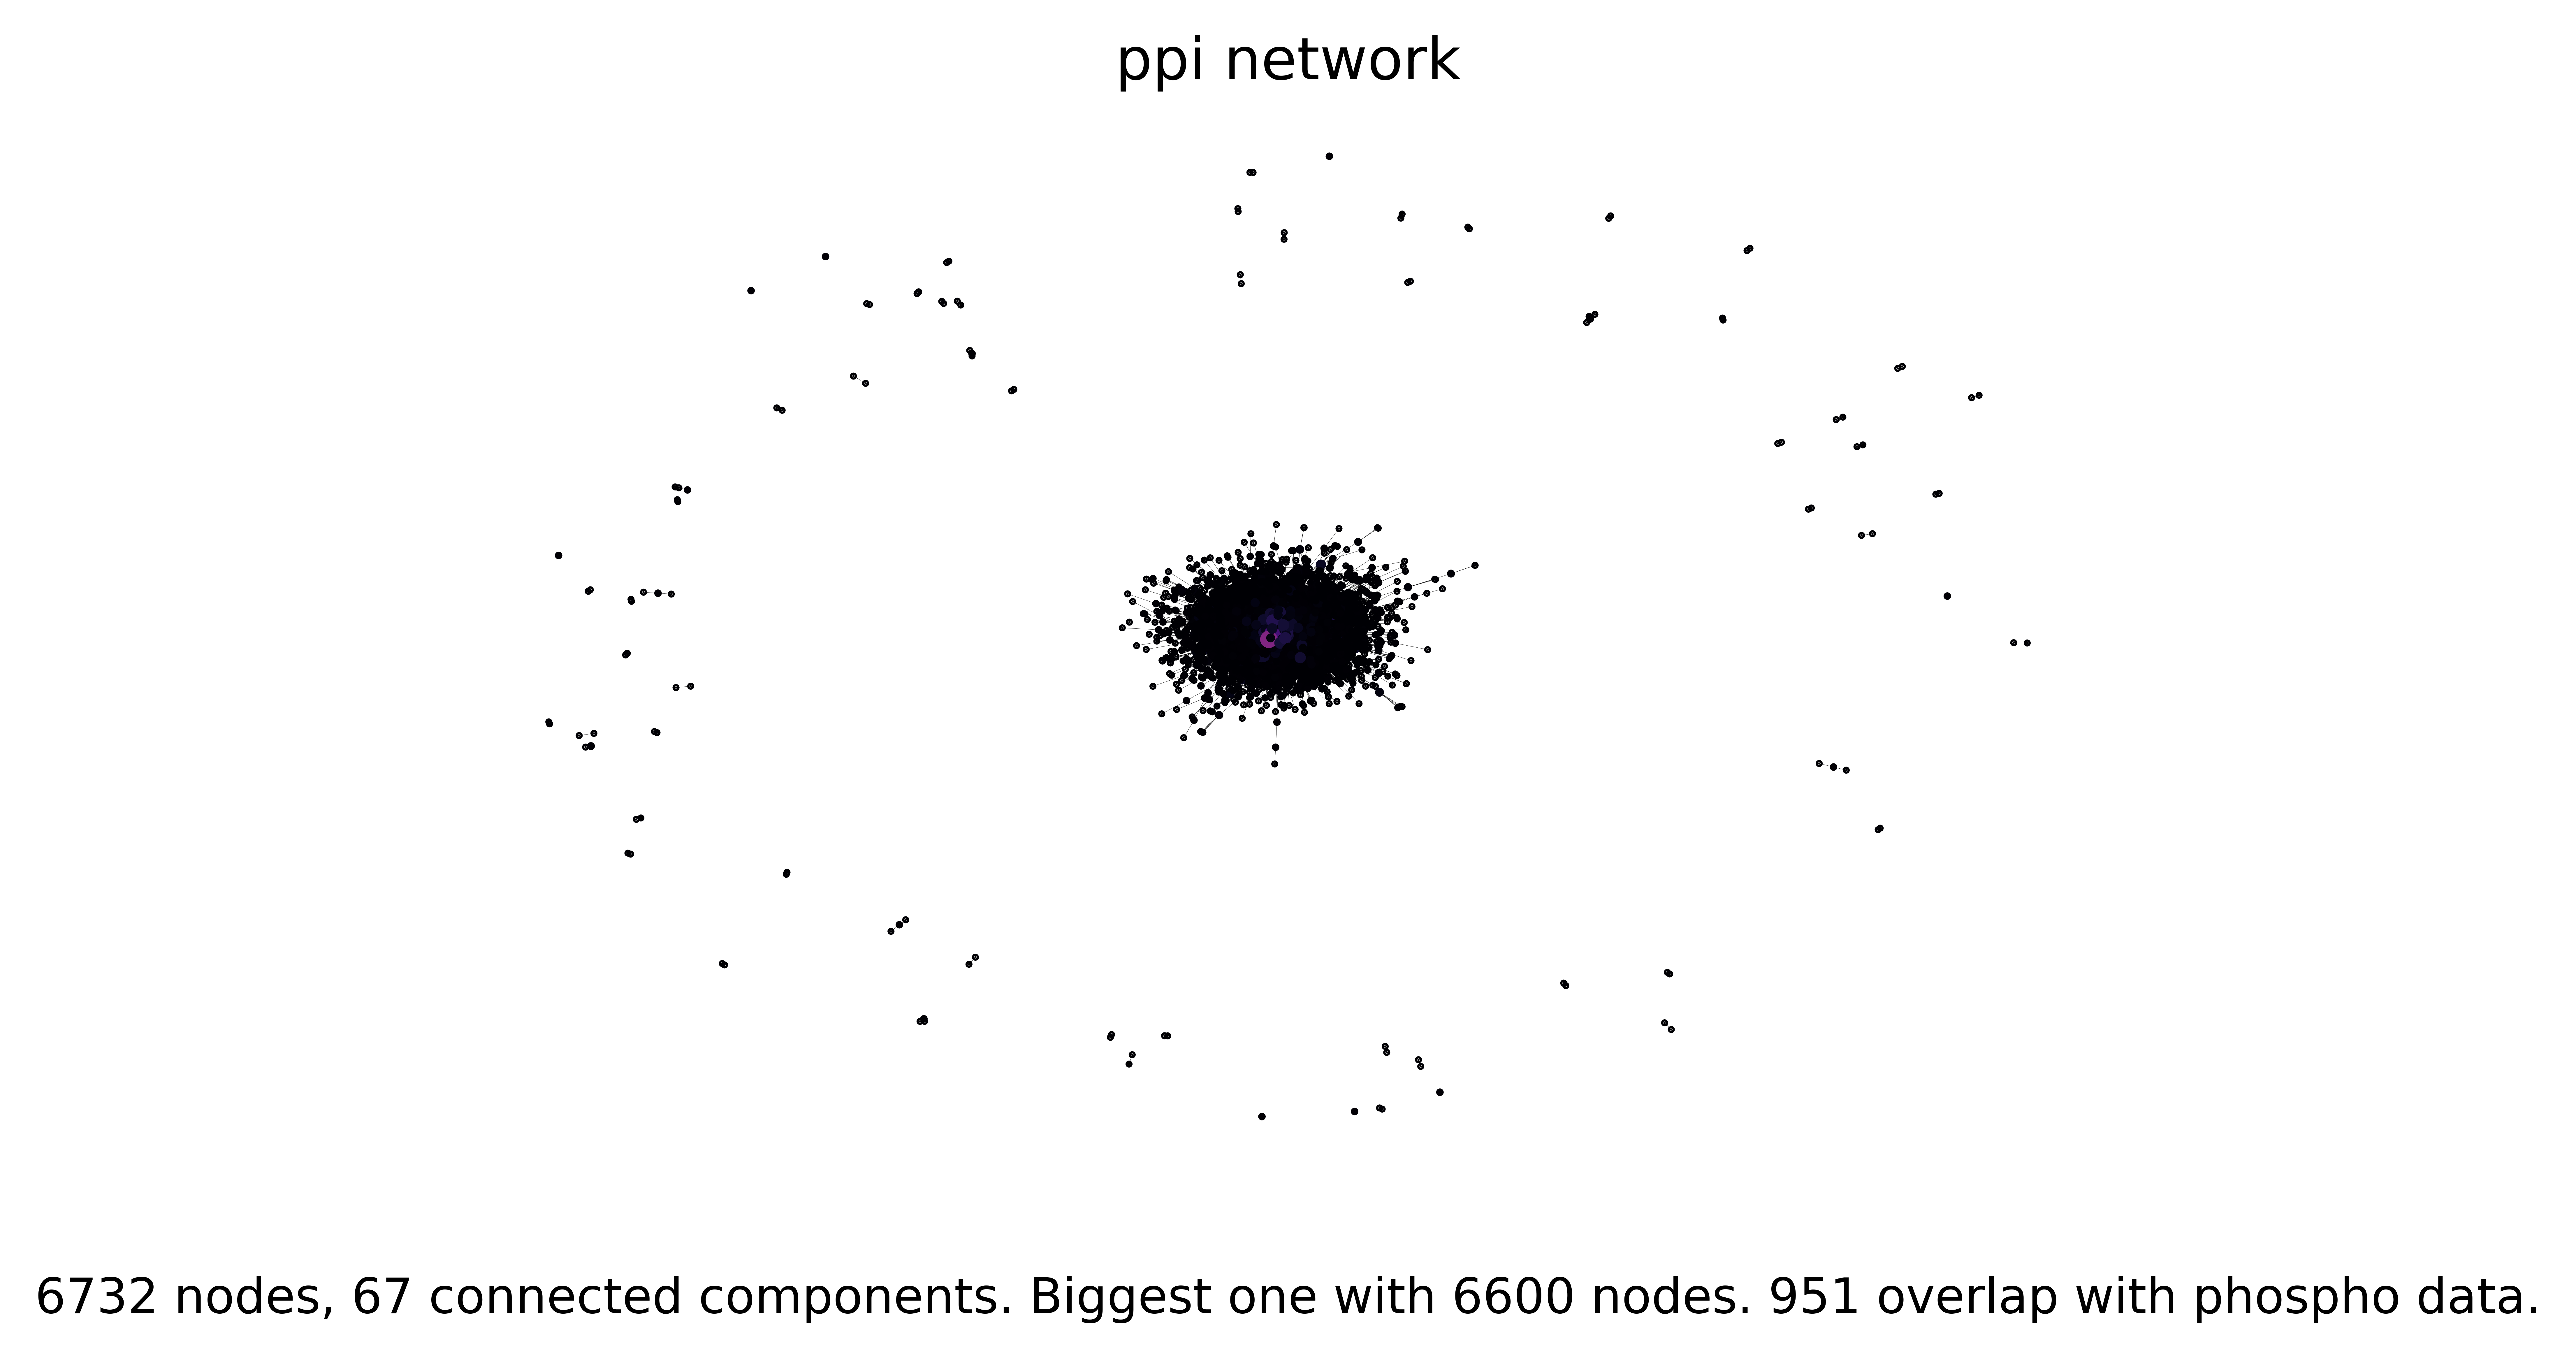

Common protein ids: 936, out of 951 in phospho data and 6600 in network


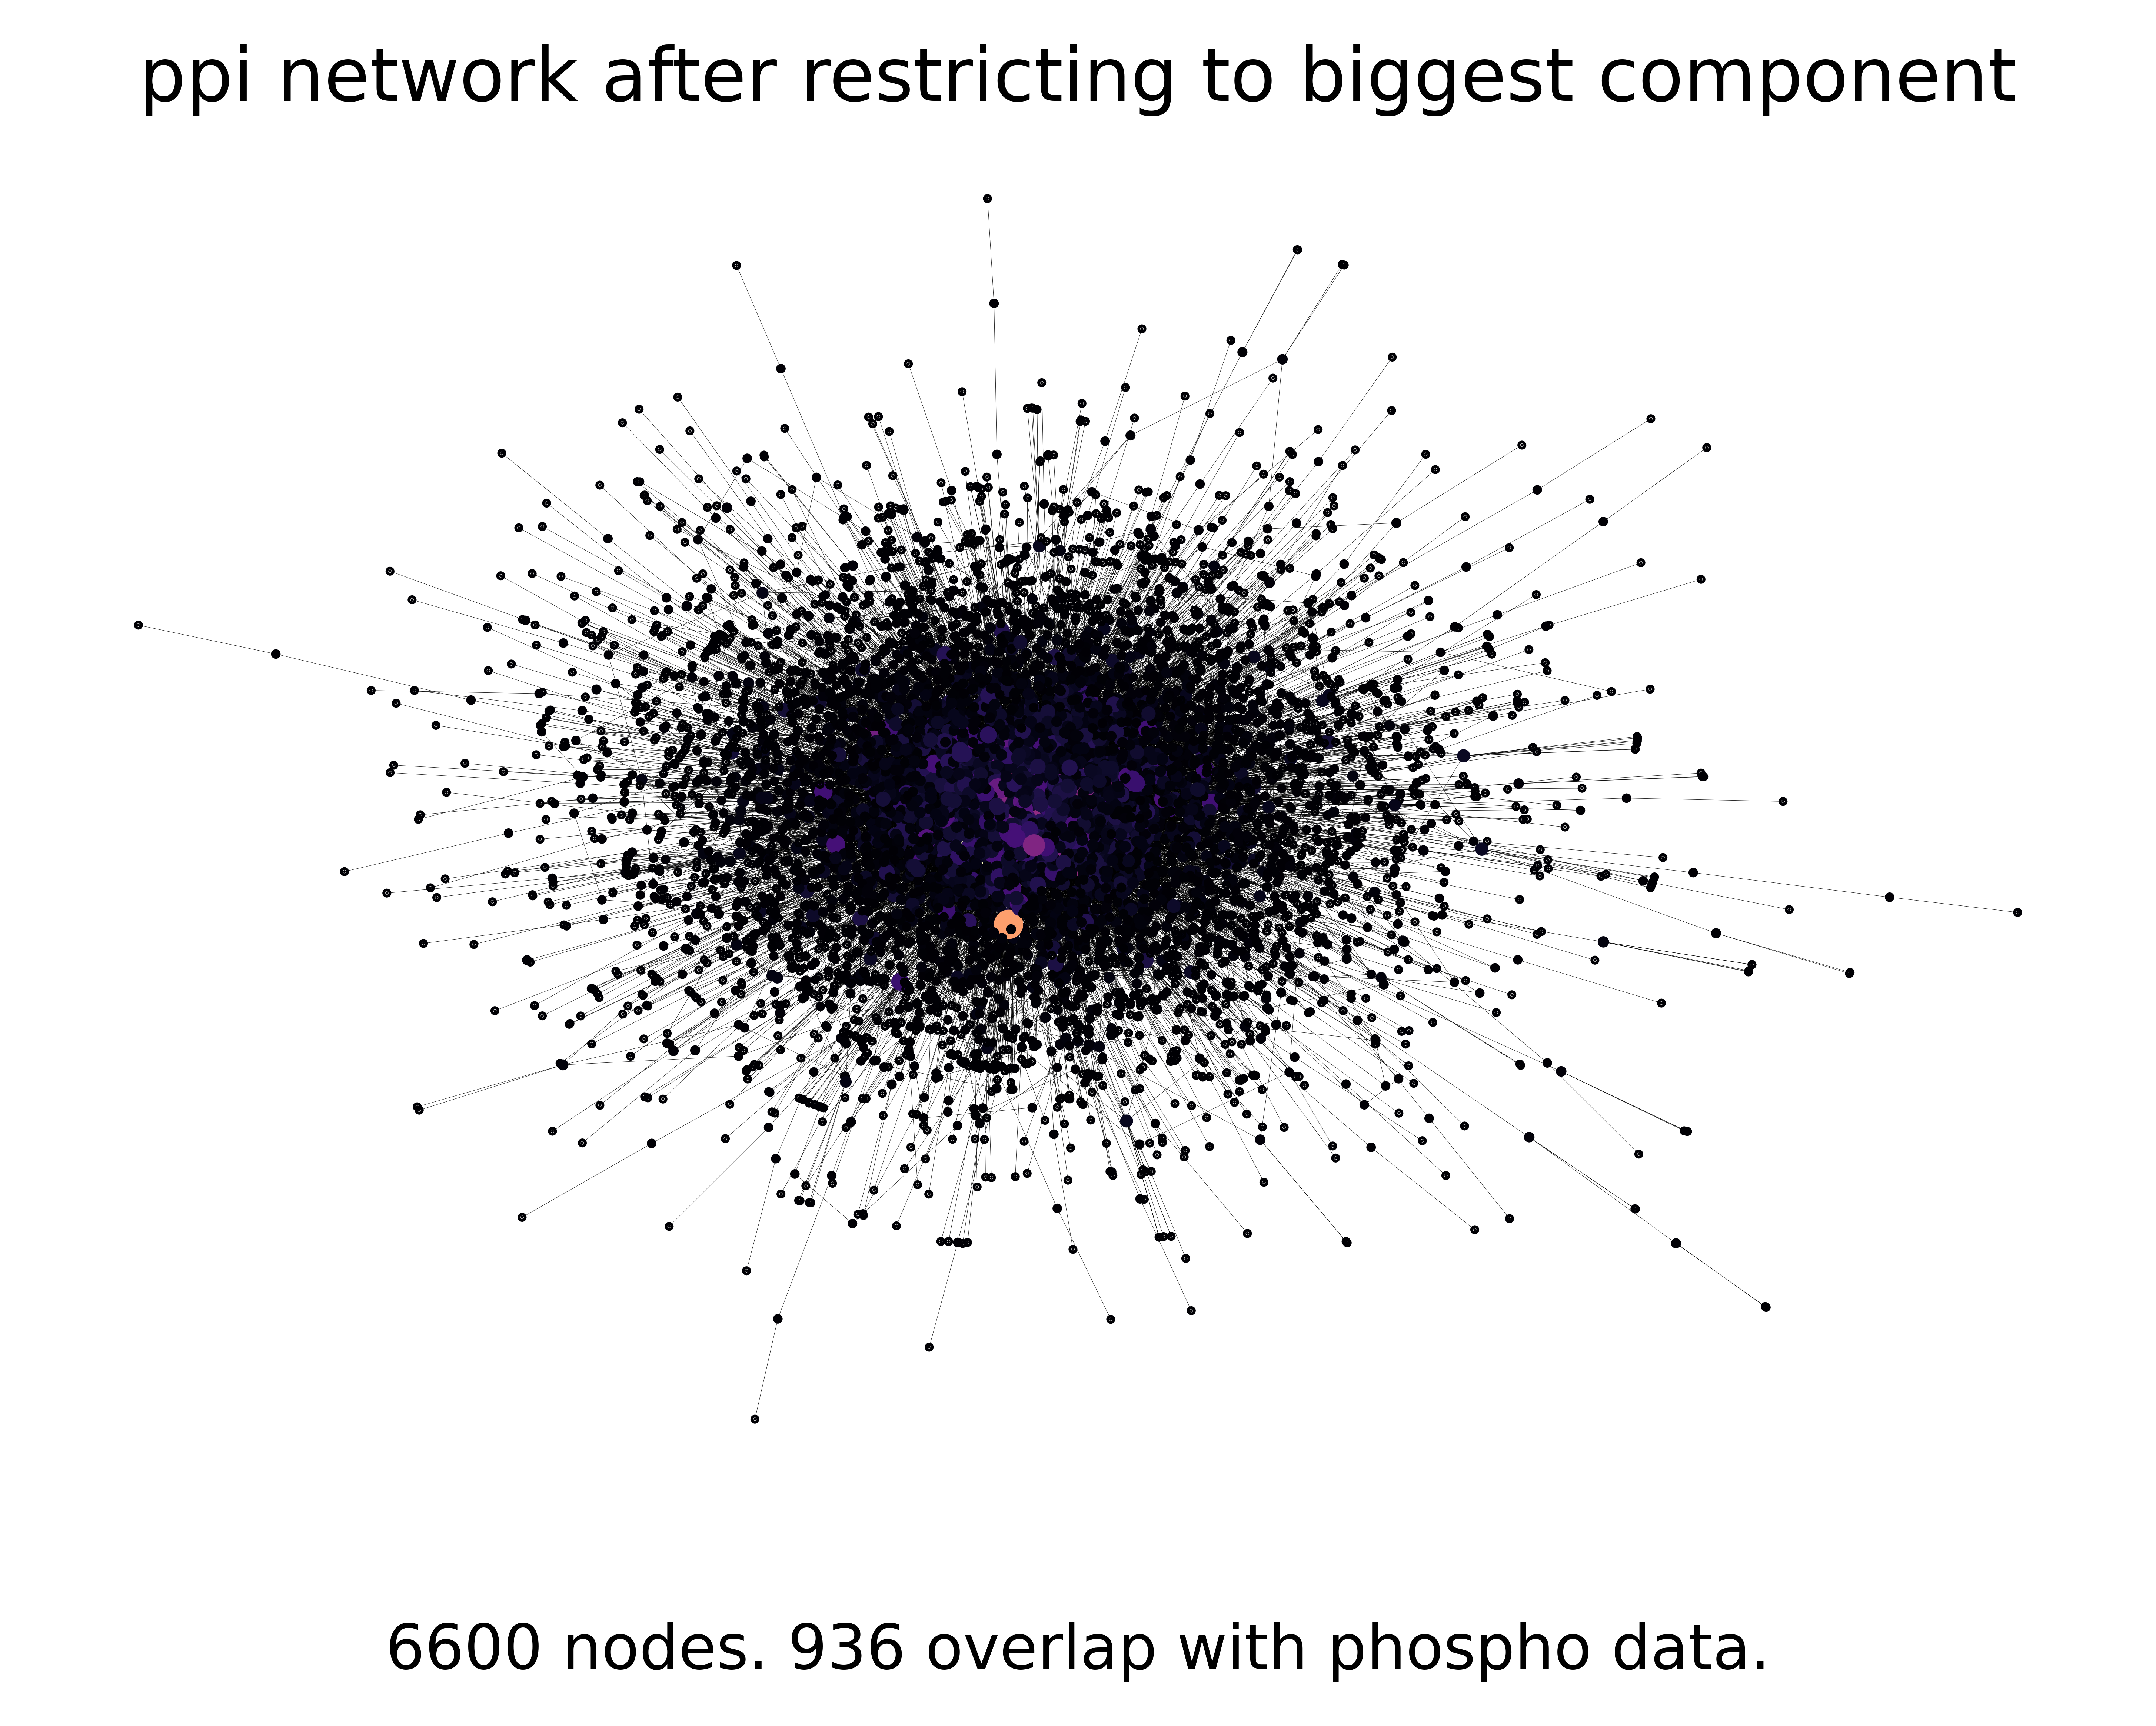

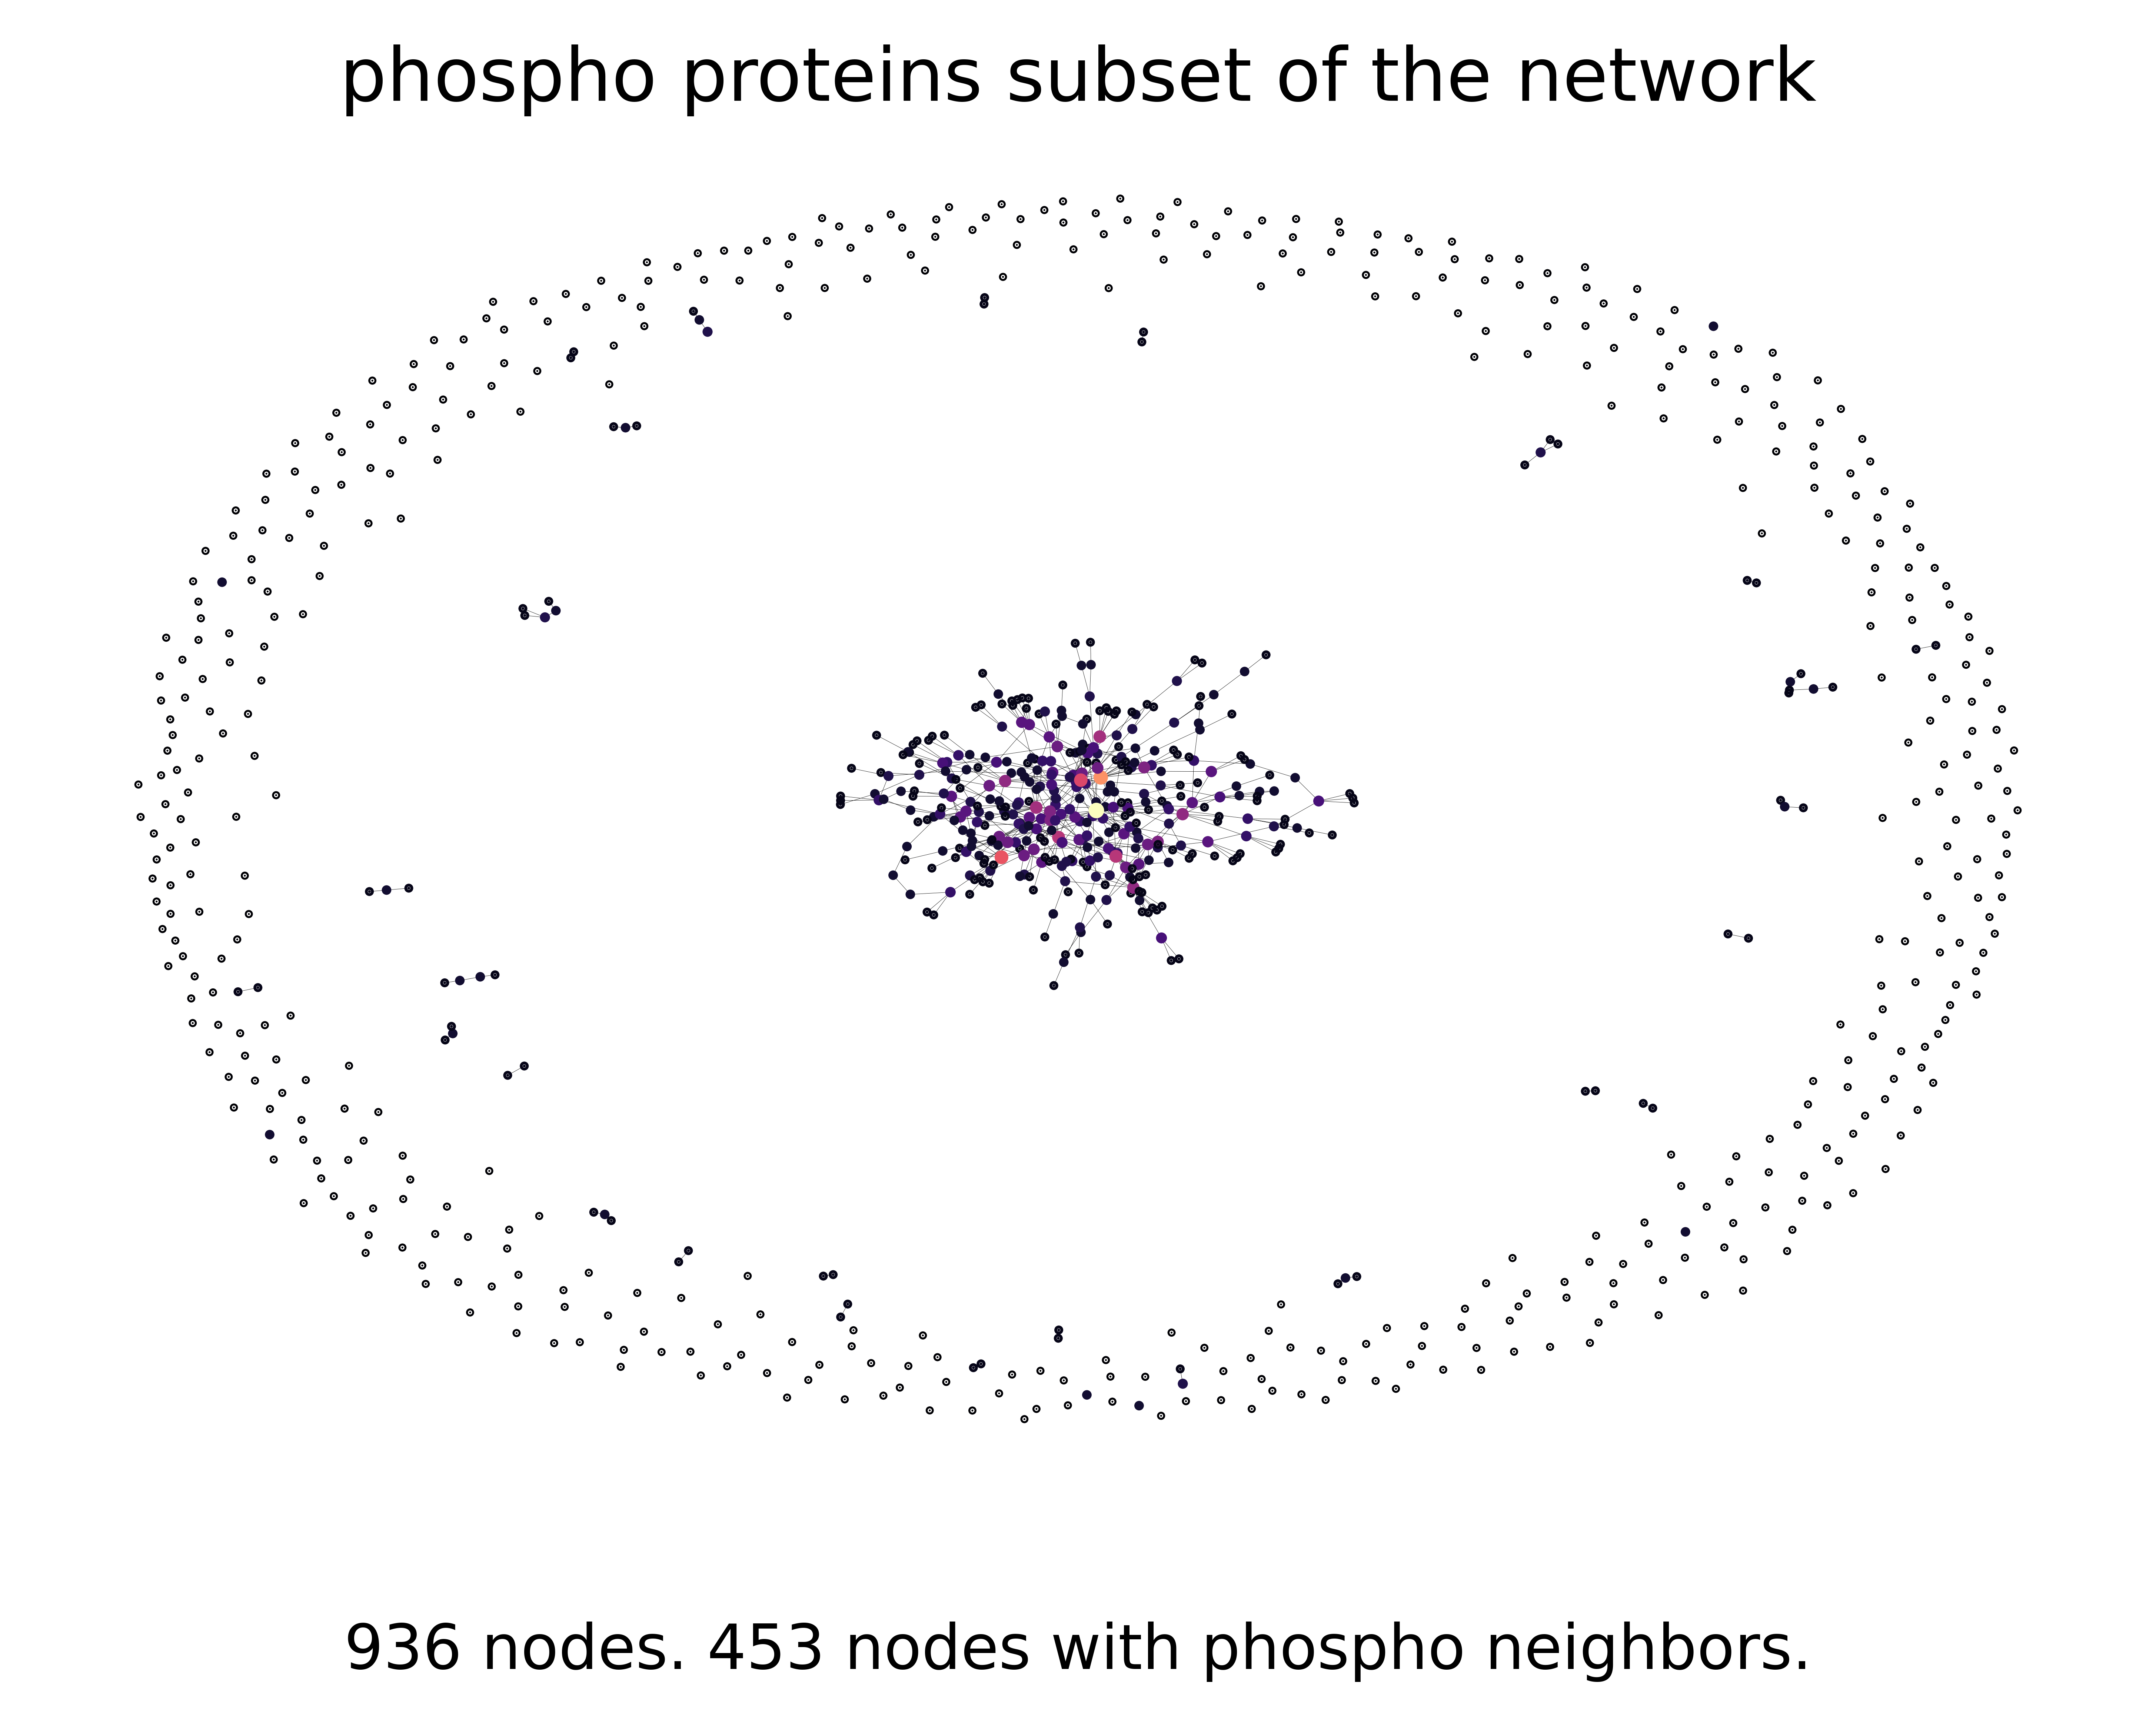

In [3]:
components = list(networkx.connected_components(ppi))

title = "ppi network"
text = """{} nodes, {} connected components. Biggest one with {} nodes. {} overlap with phospho data.""".format(
    len(ppi), len(components), len(components[0]), len(phospho_data))
plot_network(ppi, title, text)
# plotting.plot_network_visjs2jupyter(ppi, title, text)

ppi = ppi.subgraph(components[0]).copy()
phospho_data = restrict_to_common_ids(phospho_data, ppi)

title = "ppi network after restricting to biggest component"
text = """{} nodes. {} overlap with phospho data.""".format(len(ppi), len(phospho_data))
plot_network(ppi, title, text)
# plotting.plot_network_visjs2jupyter(ppi, title, text)

common_subgraph = ppi.subgraph(phospho_data.index)
n_connected = len([d for d in common_subgraph.degree if d[1] > 0])
title = "phospho proteins subset of the network"
text = """{} nodes. {} nodes with phospho neighbors.""".format(len(common_subgraph), n_connected)
plot_network(common_subgraph, title, text)
# plotting.plot_network_visjs2jupyter(ppi, title, text)

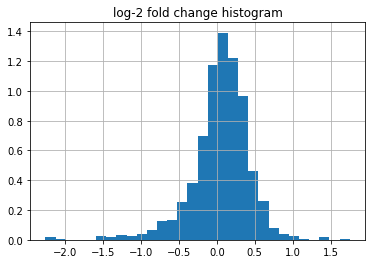

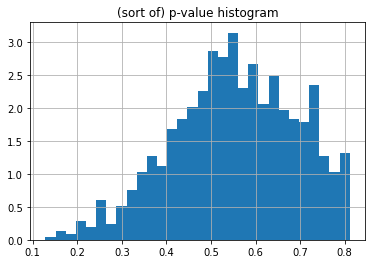

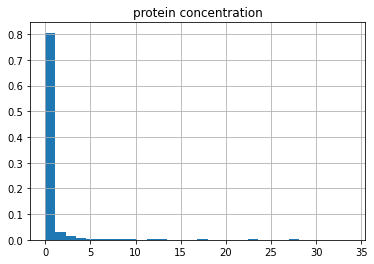

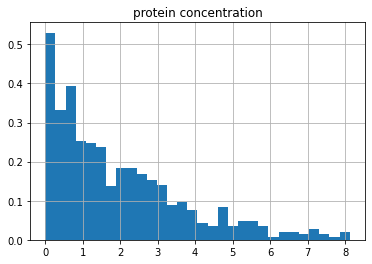

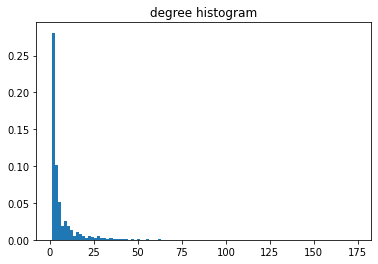

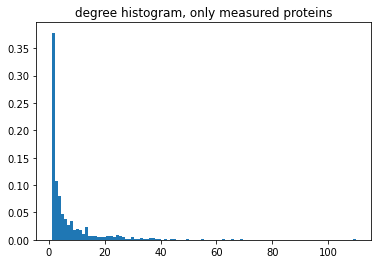

In [4]:
phospho_data['fold'].hist(density=True, bins=30)
plt.title("log-2 fold change histogram")
plt.show()

phospho_data['prob'].hist(density=True, bins=30)
plt.title("(sort of) p-value histogram")
plt.show()

phospho_data['concentration'].hist(density=True, bins=30)
plt.title("protein concentration")
plt.show()

phospho_data['concentration'] = np.log(1 + 100 * phospho_data['concentration'])
phospho_data['concentration'].hist(density=True, bins=30)
plt.title("protein concentration")
plt.show()


plt.hist([x[1] for x in ppi.degree], density=True, bins=100)
plt.title("degree histogram")
plt.show()

plt.hist([x[1] for x in ppi.degree if x[0] in phospho_data.index], density=True, bins=100)
plt.title("degree histogram, only measured proteins")
plt.show()



In [5]:
# closeness_centrality = networkx.closeness_centrality(ppi)
closeness_centrality = {u: networkx.closeness_centrality(ppi, u) for u in phospho_data.index}
betweenness_centrality = networkx.betweenness_centrality(ppi)
betweenness_centrality = {u: betweenness_centrality[u] for u in phospho_data.index}
degree_centrality = networkx.degree(ppi)
degree_centrality = {u: degree_centrality[u] for u in phospho_data.index}


vertex_metrics = closeness_centrality, betweenness_centrality, degree_centrality
vertex_metric_names = ["closeness", "betweenness", "degree_centrality"]

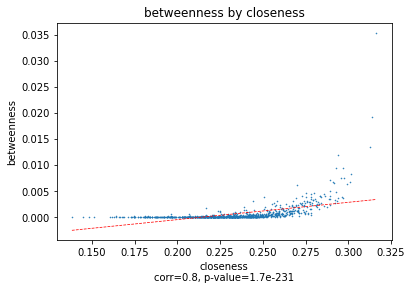

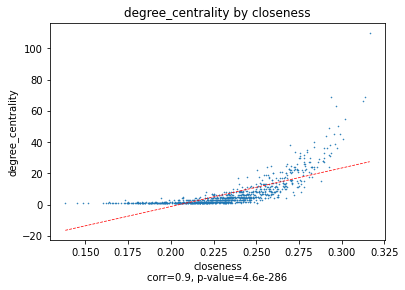

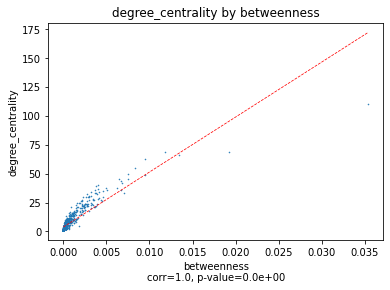

In [6]:
for (metric1, name1), (metric2, name2) in itertools.combinations(zip(vertex_metrics, vertex_metric_names), 2):
    plot_metrics_comparison(metric1, metric2, name1, name2, phospho_data.index)

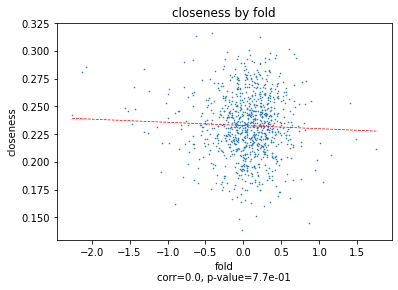

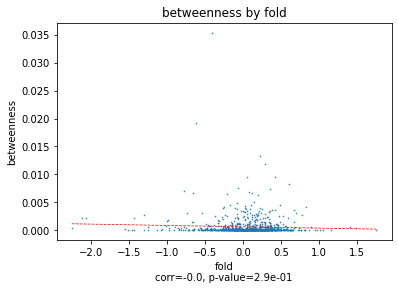

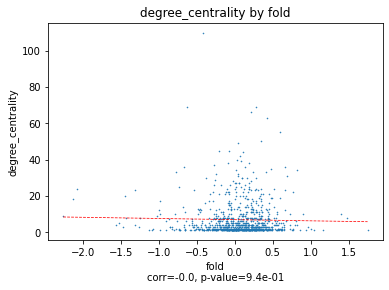

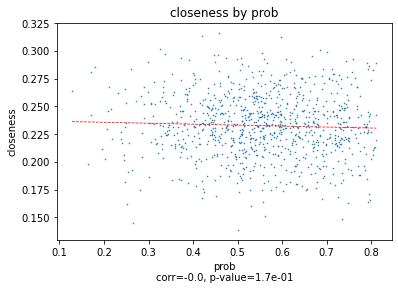

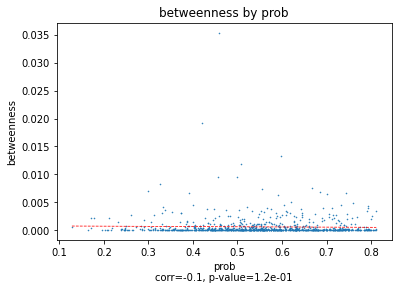

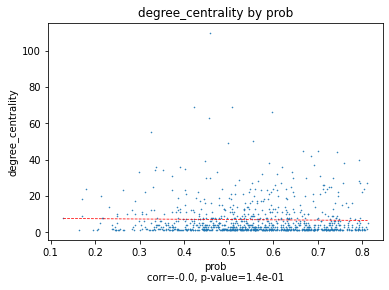

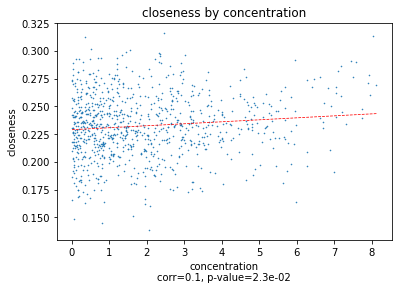

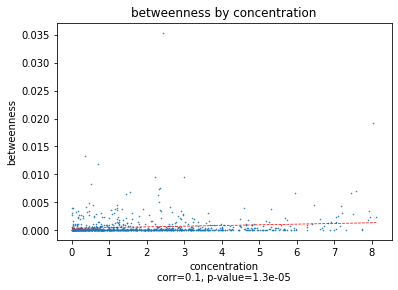

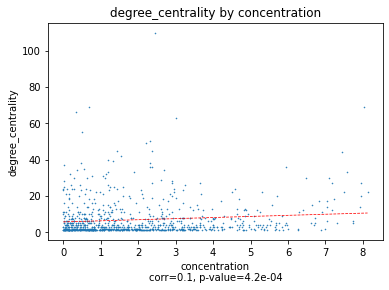

In [7]:
# Spearman correlation
for prot_metric_name in ['fold', 'prob', 'concentration']:
    prot_metric = phospho_data[prot_metric_name]
    for vertex_metric, vertex_metric_name in zip(vertex_metrics, vertex_metric_names):
        plot_metrics_comparison(prot_metric, vertex_metric, prot_metric_name, vertex_metric_name, phospho_data.index)


## Up/Down vertex analysis

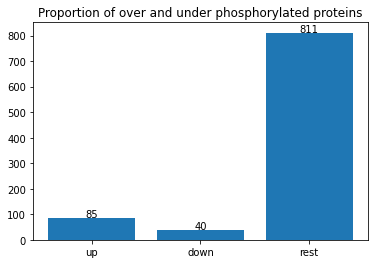

In [8]:
up_proteins, down_proteins = get_up_down_sets(phospho_data, val_threshold=0.55, p_threshold=0.38)
prots = up_proteins, down_proteins, phospho_data.index


In [9]:
up_down_centrality_analysis(*prots, vertex_metrics, vertex_metric_names)

up down analysis for metric closeness
metric means: up: 2.32e-01, down: 2.35e-01, total: 2.33e-01
p-values (against full set): up: 4.22e-01, down: 2.93e-01

up down analysis for metric betweenness
metric means: up: 6.59e-04, down: 7.33e-04, total: 6.18e-04
p-values (against full set): up: 4.60e-01, down: 1.83e-01

up down analysis for metric degree_centrality
metric means: up: 7.40e+00, down: 7.47e+00, total: 6.85e+00
p-values (against full set): up: 3.58e-01, down: 2.56e-01



In [10]:
subset_metrics = [fraction_of_internal_edges, 
                  normalized_internal_edges_size, 
                  average_shortest_path_len,
                  # average_empirical_num_shortest_paths,
                  ]
subset_metric_names = ["fraction_of_internal_edges", 
                       "normalized_internal_edges_size",
                       "average_shortest_path_len",
                       # "average_empirical_num_shortest_paths",
                       ]

## Up/Down subset analysis

Up proteins


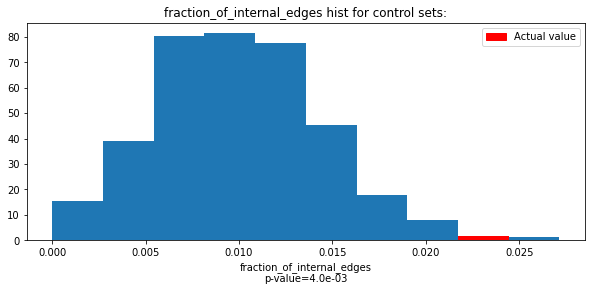

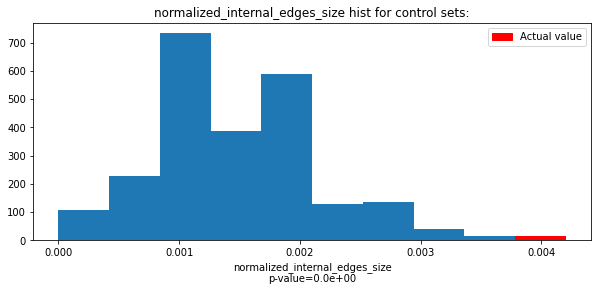

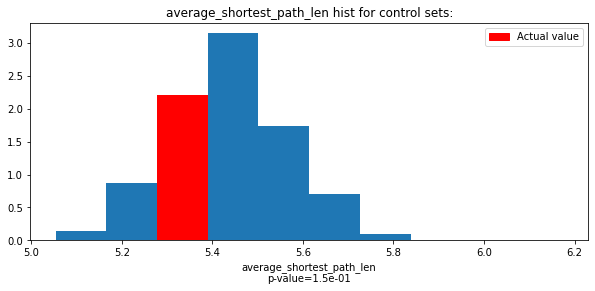

In [11]:
print("Up proteins")
topological_analysis(ppi, up_proteins, subset_metrics, subset_metric_names, random_iter=1000)


In [ ]:
print("Down proteins")
topological_analysis(ppi, down_proteins, subset_metrics, subset_metric_names, random_iter=1000)

## Propagation

In [ ]:
print("up proteins propagation")
seed_values = {n: (1 if n in up_proteins else 0) for n in phospho_data.index}
scores = cross_validate_propagation(ppi, seed_values, method='heat', 
                                    alpha=0.15, k=5, scoring='roc_auc')
print("average score: {:.3f} ({:.3f} std of scores)".format(np.mean(scores), np.std(scores)))

print("down proteins propagation")
seed_values = {n: (1  if n in down_proteins else 0) for n in phospho_data.index}
scores = cross_validate_propagation(ppi, seed_values, method='heat', 
                                    alpha=0.15, k=5, scoring='roc_auc')
print("average score: {:.3f} ({:.3f} std of scores)".format(np.mean(scores), np.std(scores)))

In [ ]:
# TODO: think of what to do with propagation when values aren't centered around 0
# or positive (or in general deal with missing values)

print("fold propagation")
seed_values = np.log2(1 + np.power(2, phospho_data['fold']))
scores = cross_validate_propagation(ppi, seed_values, method='heat', 
                                    alpha=0.15, k=5, scoring='explained_variance')
print("average score: {:.3f} ({:.3f} std of scores)".format(np.mean(scores), np.std(scores)))

In [ ]:
# TODO: think of what to do with propagation when values aren't centered around 0
# or positive (or in general deal with missing values)

print("fold propagation")
seed_values = np.log2(1 + np.power(2, phospho_data['fold']))
scores = cross_validate_propagation(ppi, seed_values, method='heat', 
                                    alpha=0.15, k=5, scoring='explained_variance')
print("average score: {:.3f} ({:.3f} std of scores)".format(np.mean(scores), np.std(scores)))

up proteins propagation


In [ ]:
# TODO: think of what to do with propagation when values aren't centered around 0
# or positive (or in general deal with missing values)

print("fold propagation")
seed_values = np.log2(1 + np.power(2, phospho_data['fold']))
scores = cross_validate_propagation(ppi, seed_values, method='heat', 
                                    alpha=0.15, k=5, scoring='explained_variance')
print("average score: {:.3f} ({:.3f} std of scores)".format(np.mean(scores), np.std(scores)))